# Results of comparison between PQ+ and PQ& for Instance Segmentation

In this notebook we will compare the two matchings on three real-world datasets and see what the main differences between the two matchings are.

## The implementation

Below is the implementation of PQ& and PQ+ for a set of binary masks and a set of predicted masks. This is mostly for demonstration purposes, depending on the dataset an algorithm based on LRE masks might be more efficient when running the prediction on all test images.

In [1]:
import json
import torch
import scipy
import itertools
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import pycocotools.coco
from itertools import cycle
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from pycocotools.coco import COCO
from collections import defaultdict
from torchvision.io import read_image
from scipy.stats import kstest, ks_2samp
from torchvision.ops import masks_to_boxes
from pycocotools.mask import decode, encode
from statsmodels.stats.weightstats import ztest
from torchvision.utils import draw_segmentation_masks

In [2]:
# Convenience function for loading in JSON files
def read_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

The function below implements the PQ+ and PQ& scores for a set of binary masks `ground_truth_masks` and a set of binary masks `prediction_masks`. 

In [3]:
def compute_matching(ground_truth_masks: np.ndarray, prediction_masks: np.ndarray, kind: str='original') -> dict:
    """
    Implements the theta& and theta+ matching conditions for an array of ground truth masks
    of shape (N, Y, X) where N is the number of objects and a predicted array of shape (M, Y, X)
    where M is the number of predicted objects
    """
    TP = []
    IOU = []
    gt_indices = list(range(ground_truth_masks.shape[0]))
    pred_indices = list(range(prediction_masks.shape[0]))
    # original denotes theta& and modified denotes theta+
    assert kind in ['original', 'modified']
    
    # Loop through all the possible combinations of predicted and ground
    # truth masks
    for i in range(ground_truth_masks.shape[0]):
        for j in range(prediction_masks.shape[0]):
            ground_truth_mask = ground_truth_masks[i, :, :]
            predicted_mask = prediction_masks[j, :, :]
            # get the union of the masks
            union = ((ground_truth_mask + predicted_mask) > 0).sum()
            # get the intersection of the masks
            intersection = (predicted_mask * ground_truth_mask).sum()
            # calculate the iou
            iou = intersection / union
            
            # original matching condition
            if kind == 'original':
                if iou > 0.5:
                    TP.append((i, j))
                    IOU.append(iou)
            # altered matching condition        
            if kind == 'modified':
                # part of masks only in ground truth
                gt_only = (ground_truth_mask.sum() - intersection)
                # part of masks only in the prediction
                pred_only = (predicted_mask.sum() - intersection)
                
                if (intersection > gt_only) and (intersection > pred_only):
                    TP.append((i, j))
                    IOU.append(iou)
    # Return TP, FP, FN and IOU
    FP = set(pred_indices)-set([item[1] for item in TP])
    FN = set(gt_indices)-set([item[0] for item in TP])
    return {'TP': TP, 'FP': FP, 'FN': FN, 'IOU': IOU}
                    
            

In [4]:
def LRE_list_to_binary_mask_dict(LRE_list):
    binary_mask_dict = defaultdict(list)
    for mask in tqdm(LRE_list):
        binary_mask = decode(mask['segmentation'])
        binary_mask_dict[mask['image_id']].append(binary_mask)
        
    for image_id, binary_list in tqdm(binary_mask_dict.items()):
        stacked_vecs = np.stack(binary_mask_dict[image_id])
        if len(stacked_vecs.shape) == 4:
            stacked_vecs = np.stack(binary_mask_dict[image_id]).squeeze(0)
        binary_mask_dict[image_id] = stacked_vecs
        
    return binary_mask_dict

## Dataloading

First we load the results from the three datasets stored in the json format. These are stored in the efficient LRE format with an entry per mask, but these have to be converted back to n-size masks for ground truth and predictions, so we do this right after the loading. We also have to load in the cityscapes dataset seperately, as this uses a slightly different format than the other two datasets.

In [5]:
coco_dataset = COCO('../data/coco.json')
lvis_dataset = COCO('../data/lvis.json')
cityscapes_dataset = COCO('../data/cityscapes_coco.json')

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=1.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


## Basic Analysis

Before we get into actually computing the differences between the two matching conditions, we will start by gathering some basic statistics on each of the datasets. Let's start by comparing the distribution of the sizes of the datasets in terms of the number of images and objects, as well as the distribution of object sizes amongst the three datasets.

In [6]:
print("The COCO dataset contains %d images and %d annotations" % (len(coco_dataset.getImgIds()), len(coco_dataset.getAnnIds())))
print("The LVIS dataset contains %d images and %d annotations" % (len(lvis_dataset.getImgIds()), len(lvis_dataset.getAnnIds())))
print("The CitysScapes dataset contains %d images and %d annotations" % (len(cityscapes_dataset.getImgIds()), len(cityscapes_dataset.getAnnIds())))

The COCO dataset contains 5000 images and 36781 annotations
The LVIS dataset contains 5000 images and 50763 annotations
The CitysScapes dataset contains 500 images and 9792 annotations


In [7]:
def get_annotation_sizes(dataset):
    areas = []
    for image_id in tqdm(dataset.getImgIds()):
        image_annotations = dataset.loadAnns(dataset.getAnnIds(image_id))
        areas.extend([annot['area'] for annot in image_annotations])
    return pd.Series(areas)

In [8]:
lvis_areas = get_annotation_sizes(lvis_dataset)
coco_areas = get_annotation_sizes(coco_dataset)
cityscapes_areas = get_annotation_sizes(cityscapes_dataset)

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 20044.27it/s]


In [9]:
print("The average object size in COCO is %d pixels" % coco_areas.mean())
print("The average object size in LVIS is %d pixels" % lvis_areas.mean())
print("The average object size in Cityscapes is %d pixels" % cityscapes_areas.mean())

The average object size in COCO is 11979 pixels
The average object size in LVIS is 5601 pixels
The average object size in Cityscapes is 8690 pixels


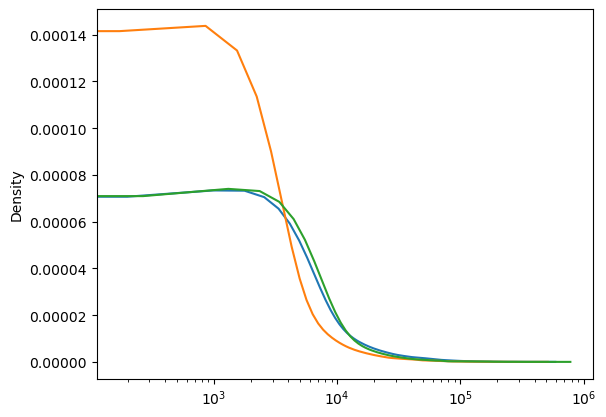

In [10]:
coco_areas.plot(kind='kde', logx=True)
lvis_areas.plot(kind='kde', logx=True)
cityscapes_areas.plot(kind='kde', logx=True)
plt.show()

In [11]:
def coco_format_to_binary_dict(dataset):
    output = {}
    classes = []
    for image in tqdm(dataset.getImgIds()):
        annotation_indices = dataset.getAnnIds(imgIds=image)
        annotations = dataset.loadAnns(annotation_indices)

        if len(annotations):
            ids = [annotation['category_id'] for annotation in annotations]
            classes.extend(ids)
            masks = [dataset.annToMask(annotation) for annotation in annotations]
            output[image] = np.stack([masks])
    return output, classes
        

Based on the sizes we skip the 25\% of the smallest clusters and calculate the TPs and all scores based only on the remaining data.

In [12]:
with open('../results/coco.json', 'r') as json_file:
    coco_results = LRE_list_to_binary_mask_dict(json.load(json_file))
with open('../results/lvis.json', 'r') as json_file:
    lvis_results = LRE_list_to_binary_mask_dict(json.load(json_file))
with open('../results/cityscapes_new.json', 'r') as json_file:
    cityscapes_results =LRE_list_to_binary_mask_dict(json.load(json_file))

100%|█████████████████████████████████████████| 494/494 [00:26<00:00, 18.83it/s]


In [13]:
coco_gold_standard, coco_classes = coco_format_to_binary_dict(coco_dataset)
lvis_gold_standard, lvis_classes = coco_format_to_binary_dict(lvis_dataset)
cityscapes_gold_standard, cityscapes_classes = coco_format_to_binary_dict(cityscapes_dataset)

100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.76it/s]


Next up we load the precomputed results of the metrics for all three datasets.

In [36]:
cityscapes_scores = read_json('../pq_results/cityscapes_new.json')
coco_scores = read_json('../pq_results/coco.json')
lvis_scores = read_json('../pq_results/lvis.json')

In [37]:
# Now get the differing TP pairs
def get_matching_differences(scores, dataset):
    all_differences = []
    for image, value in scores.items():
        different_tp_pairs = [item[0] for item in value['PQ_and']['TP'] if item not in value['PQ']['TP']]
        all_differences.extend(different_tp_pairs)
    return all_differences
    

In [38]:
coco_tps = get_matching_differences(coco_scores, coco_dataset)
lvis_tps = get_matching_differences(lvis_scores, lvis_dataset)
cityscapes_tps = get_matching_differences(cityscapes_scores, cityscapes_dataset)

In [39]:
print("There are %d new TPs for the PQ+ metric in the COCO dataset" % len(coco_tps))
print("There are %d new TPs for the PQ+ metric in the LVIS dataset" % len(lvis_tps))
print("There are %d new TPs for the PQ+ metric in the CityScapes dataset" % len(cityscapes_tps))

There are 526 new TPs for the PQ+ metric in the COCO dataset
There are 492 new TPs for the PQ+ metric in the LVIS dataset
There are 232 new TPs for the PQ+ metric in the CityScapes dataset


In [40]:
# Doe the recall thing with three 3 datasets 
cityscapes_PQ_IOU = pd.DataFrame([item for result in cityscapes_scores.values() for item in result['PQ']['IOU']])
cityscapes_PQ_and_IOU = pd.DataFrame([item for result in cityscapes_scores.values() for item in result['PQ_and']['IOU']])
cityscapes_iou = pd.concat([cityscapes_PQ_IOU, cityscapes_PQ_and_IOU])
cityscapes_iou['type'] = ['$\\theta^{+}$']*cityscapes_PQ_IOU.shape[0] + ['$\\theta^{&}$']*cityscapes_PQ_and_IOU.shape[0]

coco_PQ_IOU = pd.DataFrame([item for result in coco_scores.values() for item in result['PQ']['IOU']])
coco_PQ_and_IOU = pd.DataFrame([item for result in coco_scores.values() for item in result['PQ_and']['IOU']])
coco_iou = pd.concat([coco_PQ_IOU, coco_PQ_and_IOU])
coco_iou['type'] = ['$\\theta^{+}$']*coco_PQ_IOU.shape[0] + ['$\\theta^{&}$']*coco_PQ_and_IOU.shape[0]

lvis_PQ_IOU = pd.DataFrame([item for result in lvis_scores.values() for item in result['PQ']['IOU']])
lvis_PQ_and_IOU = pd.DataFrame([item for result in lvis_scores.values() for item in result['PQ_and']['IOU']])
lvis_iou = pd.concat([lvis_PQ_IOU, lvis_PQ_and_IOU])
lvis_iou['type'] = ['$\\theta^{+}$']*lvis_PQ_IOU.shape[0] + ['$\\theta^{&}$']*lvis_PQ_and_IOU.shape[0]

In [41]:
total_dataframe = pd.concat([cityscapes_iou, coco_iou, lvis_iou])
total_dataframe['Dataset'] = ['CityScapes']*cityscapes_iou.shape[0]+['MS COCO']*coco_iou.shape[0]+['LVIS']*lvis_iou.shape[0]

In [42]:
total_dataframe.rename({0: 'IOU'}, inplace=True, axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


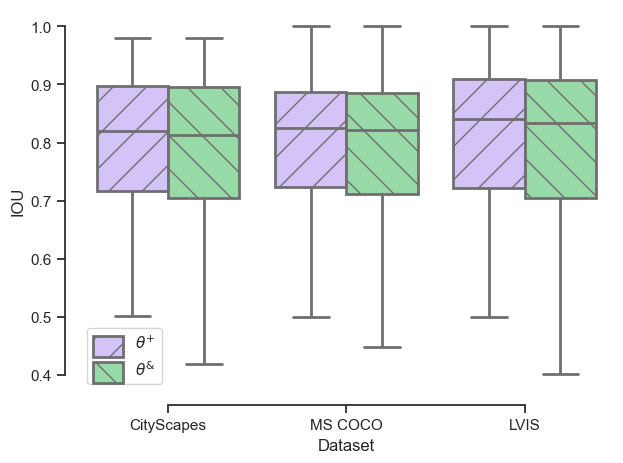

In [43]:

sns.set_theme(style="ticks", palette="pastel")
# Define some hatches
hatches = cycle(['/', '\\'])

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
ax = sns.boxplot(x="Dataset", y="IOU",
            hue="type", palette=["m", "g"],
            data=total_dataframe, showfliers=False, linewidth=2)
sns.despine(offset=10, trim=True)


# Barplot
num_locations = 3
for i, patch in enumerate(ax.patches):
    # Blue bars first, then green bars
    if i % num_locations == 0:
        hatch = next(hatches)
    patch.set_hatch(hatch)

leg = plt.legend(loc='lower left')
next(hatches)
for patch in leg.get_patches():
    patch.set_height(15)
    patch.set_y(-6)
    patch.set_hatch(next(hatches))
plt.tight_layout()
plt.savefig('../paper_images/iou_boxplot.eps', bbox_inches='tight', format='eps')

Next we test whether or not the differences between the two matchings is significant or not

In [44]:
for _, group in total_dataframe.groupby('Dataset'):
    print(group['Dataset'].unique()[0] + ' Dataset')
    #print(kstest(group[group['type'] == '$\\theta^{+}$']['IOU'], group[group['type'] == '$\\theta^{&}$']['IOU']))
    print(group[group['type'] == '$\\theta^{+}$']['IOU'].shape, group[group['type'] == '$\\theta^{&}$']['IOU'].shape)
    print(ks_2samp(group[group['type'] == '$\\theta^{+}$']['IOU'], group[group['type'] == '$\\theta^{&}$']['IOU']))
    print()

CityScapes Dataset
(6944,) (7166,)
KstestResult(statistic=0.03237510466089869, pvalue=0.0011937558323485815, statistic_location=0.5, statistic_sign=-1)

LVIS Dataset
(14053,) (14545,)
KstestResult(statistic=0.03382605706428326, pvalue=1.5369602320101921e-07, statistic_location=0.5, statistic_sign=-1)

MS COCO Dataset
(18957,) (19483,)
KstestResult(statistic=0.026997895601293436, pvalue=1.62000502621046e-06, statistic_location=0.5, statistic_sign=-1)



In [45]:
kstest(total_dataframe[(total_dataframe['Dataset'] == 'CityScapes') & (total_dataframe['type'] == '$\\theta^{+}$')]['IOU'], total_dataframe[(total_dataframe['Dataset'] == 'CityScapes') & (total_dataframe['type'] == '$\\theta^{&}$')]['IOU']
, alternative='two-sided')

KstestResult(statistic=0.03237510466089869, pvalue=0.0011937558323485815, statistic_location=0.5, statistic_sign=-1)

## Testing the true positives

In this section we are going to investigate to what extend the True positives that are newly discovered by PQ+ are valid TPs, both true a visual inspection as well as a mathematical formulation.

In [64]:
def get_PQ_and_false_hits(gold_standard, predictions, dataset_scores, pi_threshold: float=0.50):
    too_much_t_prime = 0 
    too_little_t = 0 
    total = 0
    false_hit_sizes = []
    false_hits = []
    
    # First get the pairs that are only in PQand
    different_TP_pairs = {}
    for key, value in dataset_scores.items():
        try:
            different_TP_pairs[int(key)] = [item for item in value['PQ_and']['TP'] if item not in value['PQ']['TP']]
        except:
            different_TP_pairs[key] = [item for item in value['PQ_and']['TP'] if item not in value['PQ']['TP']]
            
    for image, tp_pairs in tqdm(different_TP_pairs.items()):
        if len(tp_pairs):
            gt_indices = list(range(gold_standard[image].squeeze(0).shape[0]))
            pred_indices = list(range(predictions[image].shape[0]))
            for true_idx, pred_idx in tp_pairs:
                ground_truth_instance = gold_standard[image].squeeze(0)[true_idx] if true_idx < len(gold_standard[image].squeeze(0)) else gold_standard[image].squeeze(0)[-1]
                total+=1
                predicted_instance = predictions[image][pred_idx]
                intersection = np.logical_and(ground_truth_instance, predicted_instance)
                union = ((ground_truth_instance + predicted_instance) > 0)
                iou = intersection.sum()/ union.sum()
                gt_only = ((ground_truth_instance > 0).sum() - (intersection > 0).sum())
                gt_only_mask = (ground_truth_instance - intersection)
                pred_only = ((predicted_instance > 0).sum() - (intersection > 0).sum())
                pred_only_mask = (predicted_instance.astype(int) - intersection.astype(int))

                other_ground_truth_masks = list(set(gt_indices)-set([true_idx]))

                if len(other_ground_truth_masks):
                    for t_prime_idx in other_ground_truth_masks:
                        t_prime_mask = gold_standard[image].squeeze(0)[t_prime_idx]
                        t_prime_intersect = np.logical_and(t_prime_mask, predicted_instance)
                        condition_1 = (t_prime_intersect.sum() >= pi_threshold*intersection.sum())
                        condition_2 = (gt_only.sum() >= pi_threshold*intersection.sum())
                        if condition_1 and condition_2:
                                false_hit_sizes.append(gt_only)
                                false_hits.append((image, true_idx, pred_idx,
                                                  t_prime_intersect.sum() / intersection.sum(),
                                                  t_prime_intersect.sum() / gt_only))
                        if condition_1:
                            too_much_t_prime+=1
                        if condition_2:
                            too_little_t+=1
    return false_hits, total, false_hit_sizes
                    

In [70]:
coco_false_hits = get_PQ_and_false_hits(coco_gold_standard, coco_results, coco_scores, pi_threshold=0.75)
lvis_false_hits = get_PQ_and_false_hits(lvis_gold_standard, lvis_results, lvis_scores, pi_threshold=0.75)

100%|██████████████████████████████████████| 4193/4193 [00:15<00:00, 273.34it/s]


In [71]:
print("Of all the coco false hits, a fraction of %.2f is smaller than 1024 pixels" % (pd.Series((pd.Series(coco_false_hits[2]) < 1024).mean())).mean())
print("Of all the lvis false hits, a fraction of %.2f is smaller than 1024 pixels" % (pd.Series((pd.Series(lvis_false_hits[2]) < 1024).mean())).mean())

Of all the coco false hits, a fraction of 0.71 is smaller than 1024 pixels
Of all the lvis false hits, a fraction of 0.65 is smaller than 1024 pixels


In [72]:
len(lvis_false_hits[0])+len(coco_false_hits[0])

59

In [75]:
print("Of all new LVIS TPs, a portion of %.2f is a false positive" % (len(lvis_false_hits[0]) / lvis_false_hits[1]))
print("Of all new COCO TPs, a portion of %.2f is a false positive" % (len(coco_false_hits[0]) / coco_false_hits[1]))

Of all new LVIS TPs, a portion of 0.06 is a false positive
Of all new COCO TPs, a portion of 0.05 is a false positive


In [80]:
new_TP_pairs_iou_lvis = []

for value in lvis_scores.values():
    new_TP_indices = [i for i, PQ_and_value in enumerate(value['PQ_and']['TP']) if PQ_and_value not in value['PQ']['TP']]
    new_TP_pairs_iou_lvis.extend(np.array(value['PQ_and']['IOU'])[new_TP_indices])

In [81]:
new_TP_pairs_iou_coco = []

for value in coco_scores.values():
    new_TP_indices = [i for i, PQ_and_value in enumerate(value['PQ_and']['TP']) if PQ_and_value not in value['PQ']['TP']]
    new_TP_pairs_iou_coco.extend(np.array(value['PQ_and']['IOU'])[new_TP_indices])

In [82]:
new_TP_pairs_iou_cityscapes = []

for value in cityscapes_scores.values():
    new_TP_indices = [i for i, PQ_and_value in enumerate(value['PQ_and']['TP']) if PQ_and_value not in value['PQ']['TP']]
    new_TP_pairs_iou_cityscapes.extend(np.array(value['PQ_and']['IOU'])[new_TP_indices])

In [83]:
new_TP_pair_ser = pd.DataFrame(new_TP_pairs_iou_cityscapes)
new_TP_pair_ser_coco = pd.DataFrame(new_TP_pairs_iou_coco)
new_TP_pair_ser_lvis = pd.DataFrame(new_TP_pairs_iou_lvis)

In [84]:
plot_dataframe = np.concatenate([np.array(new_TP_pair_ser).squeeze(), np.array(new_TP_pair_ser_coco).squeeze(),
                           np.array(new_TP_pair_ser_lvis).squeeze()])
dataset_labels = ['CityScapes']*len(np.array(new_TP_pair_ser).squeeze()) + ['MS COCO']*len(np.array(new_TP_pair_ser_coco).squeeze()) + ['LVIS']*len(new_TP_pair_ser_lvis)

In [85]:
len(new_TP_pair_ser_lvis)

492

In [86]:
kde_dataframe = pd.DataFrame({'IOU': plot_dataframe, 'Dataset': dataset_labels})

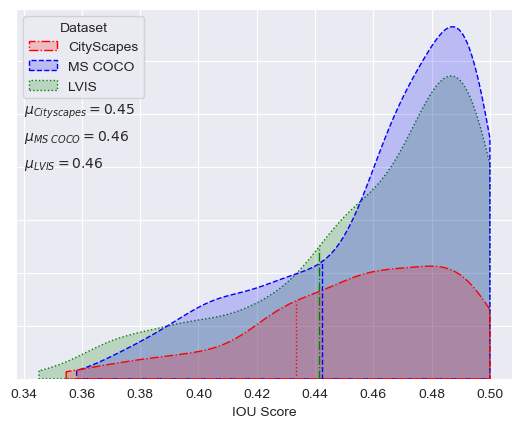

In [89]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=1)
from matplotlib import rcParams, rcParamsDefault
import matplotlib.patches as  mpatches
rcParams.update(rcParamsDefault)
sns.set_style("darkgrid")
cityscapes_mean = new_TP_pair_ser.mean()
coco_mean = new_TP_pair_ser_coco.mean()
lvis_mean = new_TP_pair_ser_lvis.mean()

cityscapes_first_q = np.percentile(new_TP_pair_ser, 25)
coco_first_q = np.percentile(new_TP_pair_ser_coco, 25)
lvis_first_q = np.percentile(new_TP_pair_ser_lvis, 25)

ax = sns.kdeplot(
   data=kde_dataframe, x="IOU", hue="Dataset",
   fill=True, alpha=0.2, palette=['red', 'blue', 'green'], cut=0, clip=[0, 1],
common_norm=True,  linestyles="--")
ax.set_yticklabels([])
ax.set_ylabel("")

ax.axvline(cityscapes_first_q, color='red', linewidth=1, linestyle=':', ymin=0, ymax=0.21)
ax.axvline(coco_first_q, color='blue', linewidth=1, linestyle='--', ymin=0, ymax=0.32)
ax.axvline(lvis_first_q, color='green', linewidth=1, linestyle='-.', ymin=0, ymax=0.36)
lss = [':', '--', '-.']

for line, ls in zip(ax.collections, lss):
    line.set_linestyle(ls)
    
plt.xlabel('IOU Score')
plt.text(0.34, 5.0, s="$\mu_{Cityscapes}=%.2f$" % cityscapes_mean)
plt.text(0.34, 4.5, s="$\mu_{MS\ COCO}=%.2f$" % coco_mean)
plt.text(0.34, 4.0, s="$\mu_{LVIS}=%.2f$" % lvis_mean)
sns.move_legend(ax, "upper left")
handles = ax.get_legend().legend_handles[::-1]
for handle, ls in zip(handles, lss):
    handle.set_ls(ls)
plt.savefig('../paper_images/iou_plot.jpeg', dpi=1000)

plt.show()